In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import numpy as np
import datetime
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

In [2]:
def summary_stats(_a, _b):
    '''Compute summary statistics for the difference between two sets.
    Input two flattened (1-D) arrays with NaN values removed'''
    
    # remove nan values
    a = _a[(np.isnan(_a)==False) & (np.isnan(_b)==False)]
    b = _b[(np.isnan(_a)==False) & (np.isnan(_b)==False)]
    
    if (len(a) == 0) or (len(b) == 0):
        diff = np.array([np.nan])
        slope, intercept, r_value, p_value, std_err = np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        # for difference stats
        diff = b - a
        # for linear regression stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(a, b)
    
    # populate dict with summary stats
    summary_stats_dict = {
        #'diff' : diff ,
        'min_diff' : np.nanmin( diff ),
        'max_diff' : np.nanmax( diff ),
        'range_diff' : np.nanmax( diff ) - np.nanmin( diff ),
        'n' : len(diff) ,
        'mean_diff' : np.nanmean( diff ),
        'median_diff' : np.nanmedian( diff ),
        'mean_squared_diff' : np.nanmean( diff**2 ),
        'rms_diff' : np.sqrt( np.nanmean( diff**2 ) ),
        'std_diff' : np.nanstd( diff ),
        'slope' : slope,
        'intercept' : intercept,
        'r_value' : r_value,
        'r_squared' : r_value**2,
        'p_value' : p_value,
        'std_err' : std_err
        }
    
    return summary_stats_dict 

In [3]:
### For 1 Jan 2021

#Read in GOES brightness temperatures

#df_merged = pd.read_csv(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\GOES-16_ABI_data\merged_datasets.csv')
#df_merged.set_index(pd.to_datetime(df_merged.datetime), inplace=True)

#Read in phase angles

df16 = pd.read_csv(r'C:\Users\steve\git\subpixel-temp-separation\SnowT_multipixel_testGOES\goes-16_phase_angles_1jan2021.csv')
df16.set_index(pd.to_datetime(df16.datetime_list), inplace=True)

df17 = pd.read_csv(r'C:\Users\steve\git\subpixel-temp-separation\SnowT_multipixel_testGOES\goes-17_phase_angles_1jan2021.csv')
df17.set_index(pd.to_datetime(df17.datetime_list), inplace=True)

In [4]:
signed_phase_angles = [df16.iloc[0].phase_angle]

for i, this_phase_angle in enumerate(df16.iloc[1:].phase_angle):
    if df16.iloc[i].phase_angle > df16.iloc[i-1].phase_angle:
        signed_phase_angles.append(-1 * this_phase_angle)
    else:
        signed_phase_angles.append(this_phase_angle)
        
df16['signed_phase_angle'] = signed_phase_angles


signed_phase_angles = [df16.iloc[0].phase_angle]

for i, this_phase_angle in enumerate(df17.iloc[1:].phase_angle):
    if df17.iloc[i].phase_angle > df17.iloc[i-1].phase_angle:
        signed_phase_angles.append(-1 * this_phase_angle)
    else:
        signed_phase_angles.append(this_phase_angle)
        
df17['signed_phase_angle'] = signed_phase_angles

In [5]:
tcc20_mean_g16 = [0.131049888, 0.271328671, 0.319058977, 0.317577706, 0.448319376]
tcc20_mean_g17 = [ 0.164508393, 0.489817052, 0.526726313, 0.357195391, 0.446153846]

In [6]:
path = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\GOES-16_ABI_data\\'

In [7]:
# GOES-16 timeseries filepaths
pixelA_g16_rad = pd.read_csv(path + 'pixelA_GOES-16_ABI_2021_01_01-02_R.csv')
pixelB_g16_rad = pd.read_csv(path + 'pixelB_GOES-16_ABI_2021_01_01-02_R.csv')
pixelC_g16_rad = pd.read_csv(path + 'pixelC_GOES-16_ABI_2021_01_01-02_R.csv')
pixelD_g16_rad = pd.read_csv(path + 'pixelD_GOES-16_ABI_2021_01_01-02_R.csv')
pixelE_g16_rad = pd.read_csv(path + 'pixelE_GOES-16_ABI_2021_01_01-02_R.csv')
# GOES-17 timeseries filepaths
pixelA_g17_rad = pd.read_csv(path + 'pixelA_GOES-17_ABI_2021_01_01-02_R.csv')
pixelB_g17_rad = pd.read_csv(path + 'pixelB_GOES-17_ABI_2021_01_01-02_R.csv')
pixelC1_g17_rad = pd.read_csv(path + 'pixelC_GOES-17_ABI_2021_01_01-02_R.csv')
pixelD_g17_rad = pd.read_csv(path + 'pixelD_GOES-17_ABI_2021_01_01-02_R.csv')
pixelE_g17_rad = pd.read_csv(path + 'pixelE_GOES-17_ABI_2021_01_01-02_R.csv')

In [8]:
df_list = [ pixelA_g16_rad, 
            pixelB_g16_rad, 
            pixelC_g16_rad, 
            pixelD_g16_rad, 
            pixelE_g16_rad, 
            pixelA_g17_rad, 
            pixelB_g17_rad, 
            pixelC1_g17_rad,
            pixelD_g17_rad, 
            pixelE_g17_rad] 

for df in df_list:
    if 't' in df.columns:
        df['datetime'] = pd.to_datetime(df.t)
    elif 'time' in df.columns:
        df['datetime'] = pd.to_datetime(df.time)
    df.set_index('datetime', inplace=True)

at what phase angles is the sun above the horizon?

In [9]:
startdate = '2021-01-01 04'

sunset1 = '2020-12-31 00:02:00'
sunrise1 = '2021-01-01 14:33:00'

sunset2 = '2021-01-02 00:02:00'
sunrise2 = '2021-01-02 14:33:00'


enddate = '2021-01-02 01'

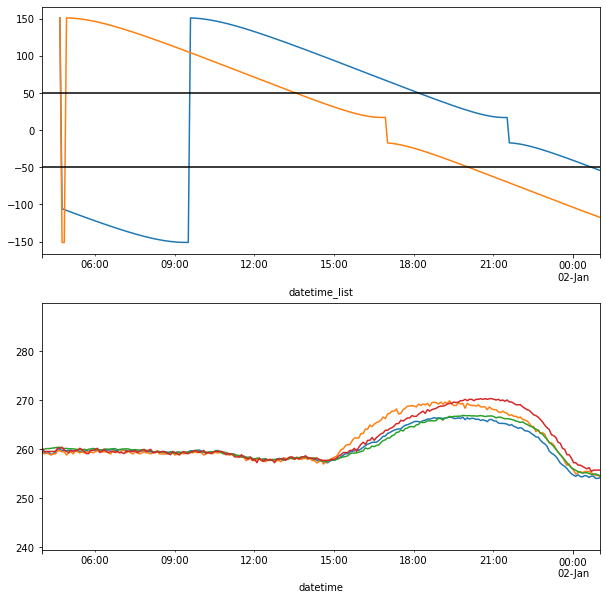

In [10]:
fig, [ax, axA] = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
df17.signed_phase_angle.plot(ax=ax)
df16.signed_phase_angle.plot(ax=ax)

# GOES-16
pixelA_g16_rad.b13_tb_2km.plot(ax=axA)
pixelA_g16_rad.b7_tb_2km.plot(ax=axA)

# GOES-17
pixelA_g17_rad.b13_tb_2km.plot(ax=axA)
pixelA_g17_rad.b7_tb_2km.plot(ax=axA)

ax.set_xlim(startdate, enddate)
axA.set_xlim(startdate, enddate)

ax.axhline(50, c='k')
ax.axhline(-50, c='k')

In [11]:
pixelA_g17_rad = pixelA_g17_rad.dropna()
pixelA_g16_rad = pixelA_g16_rad.dropna()


df17 = df17.reindex(pixelA_g17_rad.index, axis=0)
df16 = df16.reindex(pixelA_g16_rad.index, axis=0)

In [12]:
pixelA_g16_rad.index

DatetimeIndex(['2021-01-01 00:01:00', '2021-01-01 00:06:00',
               '2021-01-01 00:11:00', '2021-01-01 00:16:00',
               '2021-01-01 00:21:00', '2021-01-01 00:26:00',
               '2021-01-01 00:31:00', '2021-01-01 00:36:00',
               '2021-01-01 00:41:00', '2021-01-01 00:46:00',
               ...
               '2021-01-02 23:11:00', '2021-01-02 23:16:00',
               '2021-01-02 23:21:00', '2021-01-02 23:26:00',
               '2021-01-02 23:31:00', '2021-01-02 23:36:00',
               '2021-01-02 23:41:00', '2021-01-02 23:46:00',
               '2021-01-02 23:51:00', '2021-01-02 23:56:00'],
              dtype='datetime64[ns]', name='datetime', length=576, freq=None)

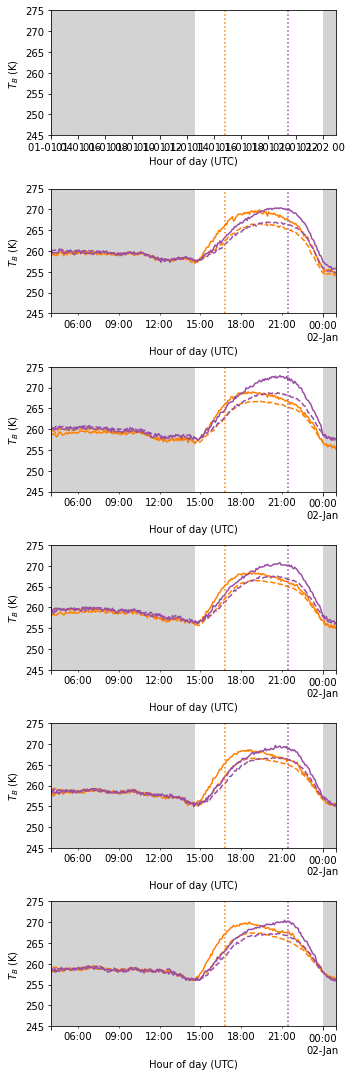

In [13]:
# plot timeseries for one pixel
fig, axs = plt.subplots(nrows=6, ncols= 1, figsize=(5,15), tight_layout=True)

[axNW, axA, axB, axC, axD, axE] = axs.ravel()

### Pixel A

# GOES-16
pixelA_g16_rad.b13_tb_2km.plot(ax=axA, color='#ff7f00', linestyle='--')
pixelA_g16_rad.b7_tb_2km.plot(ax=axA, color='#ff7f00', linestyle='-')

# GOES-17
pixelA_g17_rad.b13_tb_2km.plot(ax=axA, color='#984ea3', linestyle='--')
pixelA_g17_rad.b7_tb_2km.plot(ax=axA, color='#984ea3', linestyle='-')

### Pixel B

# GOES-16
pixelB_g16_rad.b13_tb_2km.plot(ax=axB, color='#ff7f00', linestyle='--')
pixelB_g16_rad.b7_tb_2km.plot(ax=axB, color='#ff7f00', linestyle='-')

# GOES-17
pixelB_g17_rad.b13_tb_2km.plot(ax=axB, color='#984ea3', linestyle='--')
pixelB_g17_rad.b7_tb_2km.plot(ax=axB, color='#984ea3', linestyle='-')

### Pixel C

# GOES-16
pixelC_g16_rad.b13_tb_2km.plot(ax=axC, color='#ff7f00', linestyle='--')
pixelC_g16_rad.b7_tb_2km.plot(ax=axC, color='#ff7f00', linestyle='-')

# GOES-17
pixelC1_g17_rad.b13_tb_2km.plot(ax=axC, color='#984ea3', linestyle='--')
pixelC1_g17_rad.b7_tb_2km.plot(ax=axC, color='#984ea3', linestyle='-')

### Pixel D

# GOES-16
pixelD_g16_rad.b13_tb_2km.plot(ax=axD, color='#ff7f00', linestyle='--')
pixelD_g16_rad.b7_tb_2km.plot(ax=axD, color='#ff7f00', linestyle='-')

# GOES-17
pixelD_g17_rad.b13_tb_2km.plot(ax=axD, color='#984ea3', linestyle='--')
pixelD_g17_rad.b7_tb_2km.plot(ax=axD, color='#984ea3', linestyle='-')

### Pixel E

# GOES-16
pixelE_g16_rad.b13_tb_2km.plot(ax=axE, color='#ff7f00', linestyle='--')
pixelE_g16_rad.b7_tb_2km.plot(ax=axE, color='#ff7f00', linestyle='-')

# GOES-17
pixelE_g17_rad.b13_tb_2km.plot(ax=axE, color='#984ea3', linestyle='--')
pixelE_g17_rad.b7_tb_2km.plot(ax=axE, color='#984ea3', linestyle='-')

# formatting
for this_ax in axs.ravel():
    # draw lines for times of minimum phase angles
    this_ax.axvline(pd.Timestamp('2021-01-01 16:49:00'), c='#ff7f00', linestyle=':') # time of GOES-East minimum phase angle (~8 deg)
    this_ax.axvline(pd.Timestamp('2021-01-01 21:26:00'), c='#984ea3', linestyle=':') # time of GOES-West minimum phase angle (~8 deg)
    # draw bands for nighttime (sunrise, sunset at 7:10 5:46 local time)
    this_ax.fill_between([sunset1, sunrise1], 0, 1000, color='lightgray', zorder=-999)
    this_ax.fill_between([sunset2, sunrise2], 0, 1000, color='lightgray', zorder=-999)
    this_ax.set_xlim(pd.Timestamp(startdate), pd.Timestamp(enddate))
    this_ax.set_ylim(245,275)
    this_ax.set_ylabel('$T_B$ (K)')
    this_ax.set_xlabel('Hour of day (UTC)')
    ## Text in the x-axis will be displayed in 'YYYY-mm' format.
    #this_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in this_ax.get_xticklabels(which='major'):
        label.set(rotation=0, horizontalalignment='center')
    #this_ax.legend(loc='lower left')

In [14]:
def mwir_tir_diff_plot(ax, df_rad,
                       startdate, enddate, sunrise1, sunset1, sunrise2, sunset2,
                       color):

    
    # segment data by day/night
    data_night1 = df_rad.b7_tb_2km[startdate:sunrise1] - df_rad.b13_tb_2km[startdate:sunrise1]
    data_day = df_rad.b7_tb_2km[sunrise1:sunset2] - df_rad.b13_tb_2km[sunrise1:sunset2]
    data_night2 = df_rad.b7_tb_2km[sunset2:enddate] - df_rad.b13_tb_2km[sunset2:enddate]

    # plot
    data_day.plot(ax=ax, linestyle='none', marker='.', color=color)
    data_night1.plot(ax=ax, linestyle='none', marker='x', color=color, alpha=0.5, markersize=5)
    data_night2.plot(ax=ax, linestyle='none', marker='x', color=color, alpha=0.5, markersize=5)

    return ax

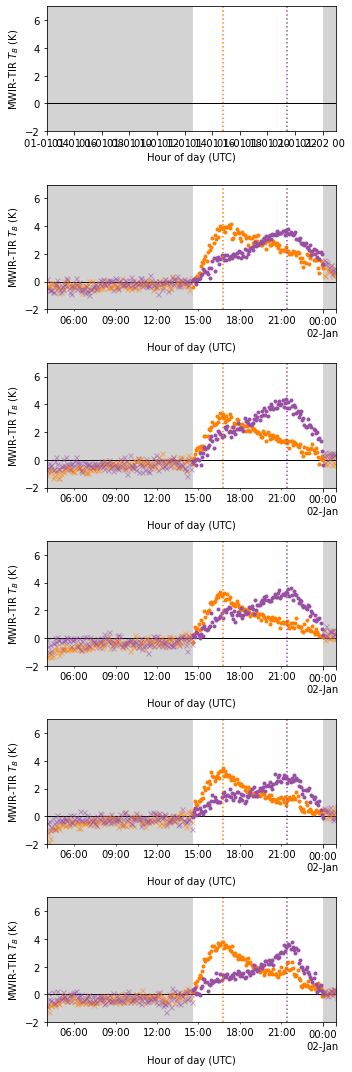

In [15]:
# plot timeseries for one pixel
fig, axs = plt.subplots(nrows=6, ncols= 1, figsize=(5,15), tight_layout=True)

[axNW, axA, axB, axC, axD, axE] = axs.ravel()


### Pixel A
axA = mwir_tir_diff_plot(axA, pixelA_g16_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#ff7f00')
axA = mwir_tir_diff_plot(axA, pixelA_g17_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#984ea3')

### Pixel B
axB = mwir_tir_diff_plot(axB, pixelB_g16_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#ff7f00')
axB = mwir_tir_diff_plot(axB, pixelB_g17_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#984ea3')

### Pixel C
axC = mwir_tir_diff_plot(axC, pixelC_g16_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#ff7f00')
axC = mwir_tir_diff_plot(axC, pixelC1_g17_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#984ea3')


### Pixel D
axD = mwir_tir_diff_plot(axD, pixelD_g16_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#ff7f00')
axD = mwir_tir_diff_plot(axD, pixelD_g17_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#984ea3')


### Pixel E
axE = mwir_tir_diff_plot(axE, pixelE_g16_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#ff7f00')
axE = mwir_tir_diff_plot(axE, pixelE_g17_rad, startdate, enddate, sunrise1, sunset1, sunrise2, sunset2, '#984ea3')

# formatting
for this_ax in axs.ravel():
    # draw lines for times of minimum phase angles
    this_ax.axvline(pd.Timestamp('2021-01-01 16:49:00'), c='#ff7f00', linestyle=':') # time of GOES-East minimum phase angle (~8 deg)
    this_ax.axvline(pd.Timestamp('2021-01-01 21:26:00'), c='#984ea3', linestyle=':') # time of GOES-West minimum phase angle (~8 deg)
    # draw bands for nighttime (sunrise, sunset at 7:10 5:46 local time)
    this_ax.fill_between([sunset1, sunrise1], -100, 1000, color='lightgray', zorder=-999)
    this_ax.fill_between([sunset2, sunrise2], -100, 1000, color='lightgray', zorder=-999)
    #this_ax.text(pd.Timestamp('2020-02-11 07:00:00'), 4.5, 'night', color='#333333')
    this_ax.axhline(0, color='k', zorder=-1, lw=1)
    this_ax.set_xlim(pd.Timestamp(startdate), pd.Timestamp(enddate))
    this_ax.set_ylim(-2,7)
    this_ax.set_ylabel('MWIR-TIR $T_B$ (K)')
    this_ax.set_xlabel('Hour of day (UTC)')
    # Text in the x-axis will be displayed in 'YYYY-mm' format.
    #this_ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
    for label in this_ax.get_xticklabels(which='major'):
        label.set(rotation=0, horizontalalignment='center')
    #this_ax.legend(loc='lower right')

In [16]:
#df17 = df17.reindex(pixelA_g17_rad.index, axis=0)
#
#g16_range_diff = []
#g16_mean_diff = []
#g16_std_diff = []
#
#g17_range_diff = []
#g17_mean_diff = []
#g17_std_diff = []
#
## plot phase angle curves
#fig, axs = plt.subplots(nrows=6, ncols= 1, figsize=(5,15), tight_layout=True)
#
#[axNW, axA, axB, axC, axD, axE] = axs.ravel()
#
#
#diff = pixelA_g16_rad.b7_tb_2km[df16.index][startdate:enddate] - pixelA_g16_rad.b13_tb_2km[df16.index][startdate:enddate]
#axA.plot(df16.signed_phase_angle[startdate:enddate], diff, '.', color='#ff7f00')
#g16_mean_diff.append(np.mean(diff))
#g16_std_diff.append(np.std(diff))
#g16_range_diff.append(np.max(diff) - np.min(diff))
#
#diff = pixelA_g17_rad.b7_tb_2km[df17.index][startdate:enddate] - pixelA_g17_rad.b13_tb_2km[df17.index][startdate:enddate]
#axA.plot(df17.signed_phase_angle[startdate:enddate], diff, '.', color='#984ea3')
#g17_mean_diff.append(np.mean(diff))
#g17_std_diff.append(np.std(diff))
#g17_range_diff.append(np.max(diff) - np.min(diff))
#
#
#diff = pixelB_g16_rad.b7_tb_2km[df16.index][startdate:enddate] - pixelB_g16_rad.b13_tb_2km[df16.index][startdate:enddate]
#axB.plot(df16.signed_phase_angle[startdate:enddate], diff, '.', color='#ff7f00')
#g16_mean_diff.append(np.mean(diff))
#g16_std_diff.append(np.std(diff))
#g16_range_diff.append(np.max(diff) - np.min(diff))
#
#diff = pixelB_g17_rad.b7_tb_2km[df17.index][startdate:enddate] - pixelB_g17_rad.b13_tb_2km[df17.index][startdate:enddate]
#axB.plot(df17.signed_phase_angle[startdate:enddate], diff, '.', color='#984ea3')
#g17_mean_diff.append(np.mean(diff))
#g17_std_diff.append(np.std(diff))
#g17_range_diff.append(np.max(diff) - np.min(diff))
#
#
#diff = pixelC_g16_rad.b7_tb_2km[df16.index][startdate:enddate] - pixelC_g16_rad.b13_tb_2km[df16.index][startdate:enddate]
#axC.plot(df16.signed_phase_angle[startdate:enddate], diff, '.', color='#ff7f00')
#g16_mean_diff.append(np.mean(diff))
#g16_std_diff.append(np.std(diff))
#g16_range_diff.append(np.max(diff) - np.min(diff))
#
#diff = pixelC1_g17_rad.b7_tb_2km[df17.index][startdate:enddate] - pixelC1_g17_rad.b13_tb_2km[df17.index][startdate:enddate]
#axC.plot(df17.signed_phase_angle[startdate:enddate], diff, '.', color='#984ea3')
#g17_mean_diff.append(np.mean(diff))
#g17_std_diff.append(np.std(diff))
#g17_range_diff.append(np.max(diff) - np.min(diff))
#
#
#
#diff = pixelD_g16_rad.b7_tb_2km[df16.index][startdate:enddate] - pixelD_g16_rad.b13_tb_2km[df16.index][startdate:enddate]
#axD.plot(df16.signed_phase_angle[startdate:enddate], diff, '.', color='#ff7f00')
#g16_mean_diff.append(np.mean(diff))
#g16_std_diff.append(np.std(diff))
#g16_range_diff.append(np.max(diff) - np.min(diff))
#
#diff = pixelD_g17_rad.b7_tb_2km[df17.index][startdate:enddate] - pixelD_g17_rad.b13_tb_2km[df17.index][startdate:enddate]
#axD.plot(df17.signed_phase_angle[startdate:enddate], diff, '.', color='#984ea3')
#g17_mean_diff.append(np.mean(diff))
#g17_std_diff.append(np.std(diff))
#g17_range_diff.append(np.max(diff) - np.min(diff))
#
#
#diff = pixelE_g16_rad.b7_tb_2km[df16.index][startdate:enddate] - pixelE_g16_rad.b13_tb_2km[df16.index][startdate:enddate]
#axE.plot(df16.signed_phase_angle[startdate:enddate], diff, '.', color='#ff7f00')
#g16_mean_diff.append(np.mean(diff))
#g16_std_diff.append(np.std(diff))
#g16_range_diff.append(np.max(diff) - np.min(diff))
#
#diff = pixelE_g17_rad.b7_tb_2km[df17.index][startdate:enddate] - pixelE_g17_rad.b13_tb_2km[df17.index][startdate:enddate]
#axE.plot(df17.signed_phase_angle[startdate:enddate], diff, '.', color='#984ea3')
#g17_mean_diff.append(np.mean(diff))
#g17_std_diff.append(np.std(diff))
#g17_range_diff.append(np.max(diff) - np.min(diff))
#
#
#
#for ax in [axNW, axA, axB, axC, axD, axE]:
#    #ax.set_xlim(-50,50)
#    ax.set_ylim(0,7)
#    ax.set_ylabel('MWIR-TIR $T_B$ (K)')
#    ax.set_xlabel('phase angle, θ ($\degree$)')
#    ax.axvline(0, color='k', zorder=-999, lw=1)

In [17]:
#plt.plot(tcc20_mean_g16, g16_mean_diff,'+', c='#ff7f00')
#plt.plot(tcc20_mean_g17, g17_mean_diff,'x', c='#984ea3')
#plt.xlabel('fveg')
#plt.ylabel('mean diff');

In [18]:
#plt.plot(tcc20_mean_g16, g16_std_diff,'+', c='#ff7f00')
#plt.plot(tcc20_mean_g17, g17_std_diff,'x', c='#984ea3')
#plt.xlabel('fveg')
#plt.ylabel('std diff');

In [19]:
#plt.plot(tcc20_mean_g16, g16_range_diff,'+', c='#ff7f00')
#plt.plot(tcc20_mean_g17, g17_range_diff,'x', c='#984ea3')
#plt.xlabel('fveg')
#plt.ylabel('range diff');

---

In [20]:
def backscatter_function(phase_angles, e0, A, B, C, D):
    
    # half width, peak magnitude, shift up or down, symetrical linear, asymmetrical linear
    
    return A / (1+(abs(phase_angles))/e0) + B + C*phase_angles# + D*phase_angles**2

In [21]:
def fit_backscatter_function(xdata, ydata):

    parameters, covariance = curve_fit(backscatter_function, xdata, ydata, maxfev=10000)
    
    x_fit = np.arange(xdata.min(),xdata.max())
    y_fit = backscatter_function(x_fit, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4])
    
    # find fwhm
    fit_max = y_fit.max()
    # create a spline of x and y_fit - half max
    spline = UnivariateSpline(x_fit, y_fit - (fit_max/2), s=0)
    fit_roots = spline.roots() # find the roots
    if len(fit_roots) == 1:
        fwhm = abs(fit_roots[0]*2)
    elif len(fit_roots) == 2:
        fwhm = fit_roots[1] - fit_roots[0]
    else:
        fwhm = np.nan
    
    rmse = np.sqrt(np.mean((backscatter_function(xdata, parameters[0], parameters[1], parameters[2], parameters[3], parameters[4]) - ydata)**2))
    print(parameters[0])
    print(f'RMSE = {str(np.round(rmse,2))}')
    
    return x_fit, y_fit, fit_max, fwhm

In [22]:
def phase_angle_plot(ax, df_phase_angles, 
                     df_rad, 
                     fit_max, fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise2, sunset2,
                     color, max_phase_angle=None):

    
    # GOES-16
    xdata_night1 = df_phase_angles.signed_phase_angle[startdate:sunrise1]
    ydata_night1 = df_rad.b7_tb_2km[df_phase_angles.index][startdate:sunrise1] - df_rad.b13_tb_2km[df_phase_angles.index][startdate:sunrise1]
    xdata_day = df_phase_angles.signed_phase_angle[sunrise1:sunset2]
    ydata_day = df_rad.b7_tb_2km[df_phase_angles.index][sunrise1:sunset2] - df_rad.b13_tb_2km[df_phase_angles.index][sunrise1:sunset2]
    xdata_night2 = df_phase_angles.signed_phase_angle[sunset2:enddate]
    ydata_night2 = df_rad.b7_tb_2km[df_phase_angles.index][sunset2:enddate] - df_rad.b13_tb_2km[df_phase_angles.index][sunset2:enddate]

    # fit curve to GOES-16 daytime phase angles only
    if max_phase_angle == None:
        print(max_phase_angle)
        x_fit, y_fit, this_fit_max, this_fwhm = fit_backscatter_function(xdata_day, ydata_day)
    else:
        print(max_phase_angle)
        x_fit, y_fit, this_fit_max, this_fwhm = fit_backscatter_function(xdata_day[(xdata_day>-max_phase_angle) & (xdata_day<max_phase_angle)], ydata_day[(xdata_day>-max_phase_angle) & (xdata_day<max_phase_angle)])
    
    fit_max.append(this_fit_max)
    fwhm.append(this_fwhm)
    ax.plot(x_fit,y_fit,'-', color='k', alpha=0.6, lw=1, zorder=9999)
    ax.plot(xdata_day, ydata_day, '.', color=color)
    ax.plot(xdata_night1, ydata_night1, 'x', color=color, alpha=0.5, markersize=5)
    ax.plot(xdata_night2, ydata_night2, 'x', color=color, alpha=0.5, markersize=5)
    #ax.text(xtext, ytext, f'max: {str(np.round(fit_max,1))}\nFWHM: {str(np.round(fwhm,1))}', color=color)

    return ax, fit_max, fwhm

A
50


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.0007539025001256233
RMSE = 0.38
50
-0.00022170275200628155
RMSE = 0.22
B
50
0.0013059474384447102
RMSE = 0.31
50
150.6217277874463
RMSE = 0.33
C
50
0.000693543566499681
RMSE = 0.3
50
-0.00027638810218485424
RMSE = 0.29
D
50
0.005693093907120582
RMSE = 0.28
50
-0.0003369592337101802
RMSE = 0.31
E
50
-0.0015619162765342781
RMSE = 0.33
50
-1.4888595440332886
RMSE = 0.3


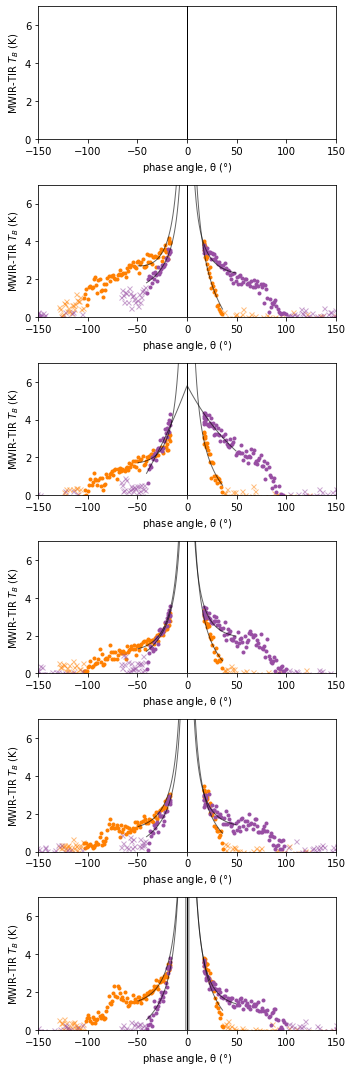

In [23]:
xtext, ytext = -45, 6
xtext2, ytext2 = 25, 6

g16_fit_max = []
g16_fwhm = []

g17_fit_max = []
g17_fwhm = []

max_phase_angle = 50

# plot phase angle curves
fig, axs = plt.subplots(nrows=6, ncols= 1, figsize=(5,15), tight_layout=True)

[axNW, axA, axB, axC, axD, axE] = axs.ravel()


print('A')
axA, g16_fit_max, g16_fwhm = phase_angle_plot(axA, df16, pixelA_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axA, g17_fit_max, g17_fwhm = phase_angle_plot(axA, df17, pixelA_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

print('B')
axB, g16_fit_max, g16_fwhm = phase_angle_plot(axB, df16, pixelB_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axB, g17_fit_max, g17_fwhm = phase_angle_plot(axB, df17, pixelB_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)
print('C')
axC, g16_fit_max, g16_fwhm = phase_angle_plot(axC, df16, pixelC_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axC, g17_fit_max, g17_fwhm = phase_angle_plot(axC, df17, pixelC1_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

print('D')
axD, g16_fit_max, g16_fwhm = phase_angle_plot(axD, df16, pixelD_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axD, g17_fit_max, g17_fwhm = phase_angle_plot(axD, df17, pixelD_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)
print('E')
axE, g16_fit_max, g16_fwhm = phase_angle_plot(axE, df16, pixelE_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axE, g17_fit_max, g17_fwhm = phase_angle_plot(axE, df17, pixelE_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

for ax in [axNW, axA, axB, axC, axD, axE]:
    ax.axvline(0, color='k', zorder=-999, lw=1)
    ax.set_xlim(-150,150)
    ax.set_ylim(0,7)
    ax.set_ylabel('MWIR-TIR $T_B$ (K)')
    ax.set_xlabel('phase angle, θ ($\degree$)')

A
50
0.0007539025001256233
RMSE = 0.38
50
-0.00022170275200628155
RMSE = 0.22
B
50
0.0013059474384447102
RMSE = 0.31
50
150.6217277874463
RMSE = 0.33
C
50
0.000693543566499681
RMSE = 0.3
50
-0.00027638810218485424
RMSE = 0.29
D
50
0.005693093907120582
RMSE = 0.28
50
-0.0003369592337101802
RMSE = 0.31
E
50
-0.0015619162765342781
RMSE = 0.33
50
-1.4888595440332886
RMSE = 0.3


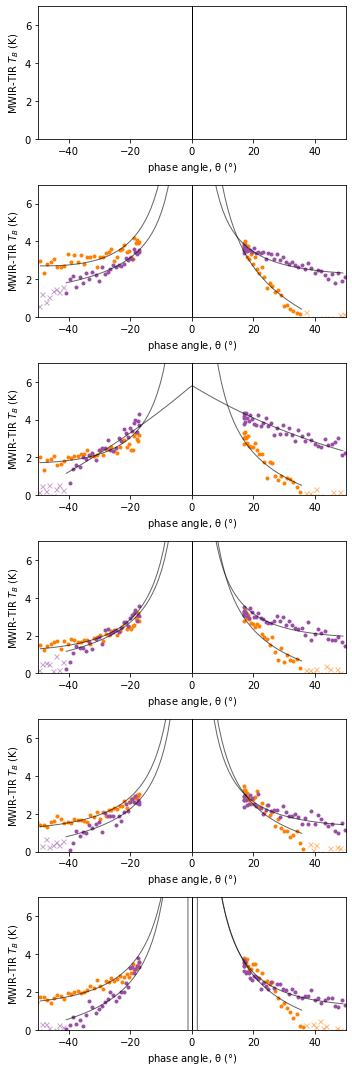

In [24]:
xtext, ytext = -45, 6
xtext2, ytext2 = 25, 6

g16_fit_max = []
g16_fwhm = []

g17_fit_max = []
g17_fwhm = []

max_phase_angle = 50

# plot phase angle curves
fig, axs = plt.subplots(nrows=6, ncols= 1, figsize=(5,15), tight_layout=True)

[axNW, axA, axB, axC, axD, axE] = axs.ravel()


print('A')
axA, g16_fit_max, g16_fwhm = phase_angle_plot(axA, df16, pixelA_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axA, g17_fit_max, g17_fwhm = phase_angle_plot(axA, df17, pixelA_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

print('B')
axB, g16_fit_max, g16_fwhm = phase_angle_plot(axB, df16, pixelB_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axB, g17_fit_max, g17_fwhm = phase_angle_plot(axB, df17, pixelB_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)
print('C')
axC, g16_fit_max, g16_fwhm = phase_angle_plot(axC, df16, pixelC_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axC, g17_fit_max, g17_fwhm = phase_angle_plot(axC, df17, pixelC1_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

print('D')
axD, g16_fit_max, g16_fwhm = phase_angle_plot(axD, df16, pixelD_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axD, g17_fit_max, g17_fwhm = phase_angle_plot(axD, df17, pixelD_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)
print('E')
axE, g16_fit_max, g16_fwhm = phase_angle_plot(axE, df16, pixelE_g16_rad, g16_fit_max, g16_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#ff7f00', max_phase_angle)
axE, g17_fit_max, g17_fwhm = phase_angle_plot(axE, df17, pixelE_g17_rad, g17_fit_max, g17_fwhm,
                     startdate, enddate, sunrise1, sunset1, sunrise1, sunset2,
                     '#984ea3', max_phase_angle)

for ax in [axNW, axA, axB, axC, axD, axE]:
    ax.axvline(0, color='k', zorder=-999, lw=1)
    ax.set_xlim(-50,50)
    ax.set_ylim(0,7)
    ax.set_ylabel('MWIR-TIR $T_B$ (K)')
    ax.set_xlabel('phase angle, θ ($\degree$)')

In [25]:
print(g16_fit_max)
print(g16_fwhm)
print(g17_fit_max)
print(g17_fwhm)

[254.89881526965056, 210.74050391636146, 214.87117344461592, 201.12263100354633, 247.15643001080866]
[1.5866922078957704, 1.5868143305382394, 1.5853297575664602, 1.5938009719005621, 1.5830128521268483]
[360.8446290905687, 5.790377478348004, 403.4084847921991, 396.1818260203619, 158.33646676415324]
[1.2740428790992149, 62.20095022655671, 1.2723812174064149, 1.2713920240650576, nan]


[-37.67903676617965, 236.96617788004332, -0.1808245411424821, 0.7710279445388429, 118.32130326801251]
[-465.3062580005394, 449.5831971003256, -0.38164128539339165, 0.5261471053284699, 650.6400761586722]


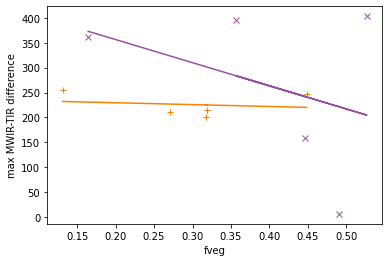

In [26]:
plt.plot(tcc20_mean_g16, g16_fit_max,'+', c='#ff7f00')

slope, intercept, r, p, se = stats.linregress(tcc20_mean_g16, g16_fit_max, alternative='two-sided')
print([slope, intercept, r, p, se])
plt.plot(tcc20_mean_g16, np.array(tcc20_mean_g16)*slope + intercept, c='#ff7f00')


plt.plot(tcc20_mean_g17, g17_fit_max,'x', c='#984ea3')

slope, intercept, r, p, se = stats.linregress(tcc20_mean_g17, g17_fit_max, alternative='two-sided')
print([slope, intercept, r, p, se])
plt.plot(tcc20_mean_g17, np.array(tcc20_mean_g17)*slope + intercept, c='#984ea3')

plt.xlabel('fveg')
plt.ylabel('max MWIR-TIR difference');

[-0.008550861332074843, 1.5896736224201586, -0.2418944142141692, 0.695040955870146, 0.019802981491791938]
[nan, nan, nan, nan, nan]


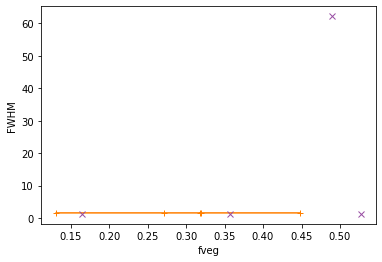

In [27]:
plt.plot(tcc20_mean_g16, g16_fwhm,'+', c='#ff7f00')

slope, intercept, r, p, se = stats.linregress(tcc20_mean_g16, g16_fwhm, alternative='two-sided')
print([slope, intercept, r, p, se])
plt.plot(tcc20_mean_g16, np.array(tcc20_mean_g16)*slope + intercept, c='#ff7f00')

plt.plot(tcc20_mean_g17, g17_fwhm,'x', c='#984ea3')

slope, intercept, r, p, se = stats.linregress(tcc20_mean_g17, g17_fwhm, alternative='two-sided')
print([slope, intercept, r, p, se])
plt.plot(tcc20_mean_g17, np.array(tcc20_mean_g17)*slope + intercept, c='#984ea3')

plt.xlabel('fveg')
plt.ylabel('FWHM');

In [28]:
tcc20_mean_g17

[0.164508393, 0.489817052, 0.526726313, 0.357195391, 0.446153846]